# 2D object detection --SSD(pytorch)

This notebook is written to introduce the whole process of deep learning. Here I choose the pytorch version of SSD as an example to show how to train, evaluate and test a model.

This notebook requires **python version of 3.7 and pytorch version of 1.3 with cuda, this notebook cannot run without cuda**!

pytorch1.3 can get from https://pytorch.org/get-started/locally/

## Before getting started

Before getting started, make sure you have installed necessary packages listed below: if not, type the command behind them in your terminal to install them                 

 - opencv: `pip install opencv-python`
 - visdom: `pip install visdom`
 - numpy: `pip install numpy`
 - matplotlib:`pip install matplotlib`

The dataset I use in this process is VOC2007, so you need to download it at [http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar)

Unzip it to VOCdevkit directory and the path should look like this
```
├─VOCdevkit
│  ├─results
│  │  └─VOC2007
│  │      └─Main
│  └─VOC2007
│      ├─Annotations
│      ├─ImageSets
│      │  ├─Layout
│      │  ├─Main
│      │  └─Segmentation
│      ├─JPEGImages
│      ├─SegmentationClass
│      └─SegmentationObject
```
In the original directory there is a txt file named val1.txt, it's made by myself because the original val.txt in `./VOCdevkit/VOC2007/ImageSets/Main/` is so large that if we do evaluation with this txt it will cost a lot of time, so I extract some contents from val.txt and make val1.txt. Thus remember to
**move the `val1.txt` to `./VOCdevkit/VOC2007/ImageSets/Main/`** after you download VOC2007 

Also,our model need a pre-parameter of VGG16, so you need to download the vgg16-parameters to the **weights** directory from [https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth](https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth)

## Training process

### import what we need in the training process

In [1]:
import torch
import Config
import torch.nn as nn
import cv2
import utils
import loss_function
import voc0712
import voc0713
import augmentations
import ssd_net_vgg
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
import os
import time
from visdom import Visdom
from tools import adjust_learning_rate,detection_collate,xavier,weights_init,test_net
from detection import *
from ssd_net_vgg import *
from voc0712 import *
import numpy as np
import json
import pylab
from matplotlib import pyplot as plt

if Config.use_cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
if not Config.use_cuda:
    print("WARNING: It looks like you have a CUDA device, but aren't " +
          "using CUDA.\nRun with --cuda for optimal training speed.")
    torch.set_default_tensor_type('torch.FloatTensor')

save_folder = os.path.join('save_folder/')
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
test_save_dir = os.path.join(save_folder, 'ss_predict')
if not os.path.exists(test_save_dir):
    os.makedirs(test_save_dir)

### setting up visdom for visualization

**open your terminal, and type `visdom` or `python -m visdom.server`**,after this, you can see 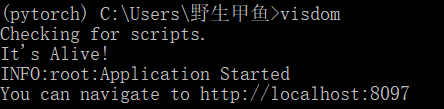

click http://localhost:8097 as it says, you can open a webpage like this:
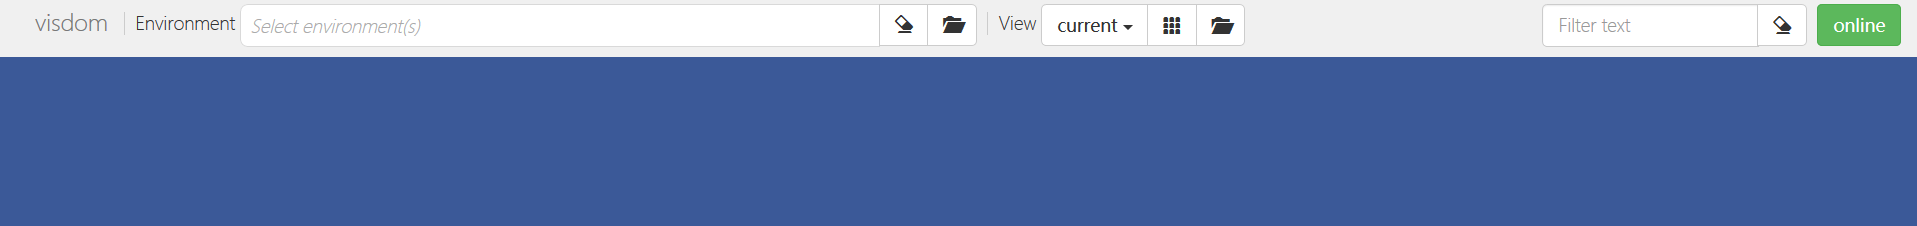

Then run the cell below:

In [2]:
viz = Visdom(env = 'ssd',port = 8097)

Setting up a new session...


After finishing the above cell, go to http://localhost:8097, and select environment 'ssd'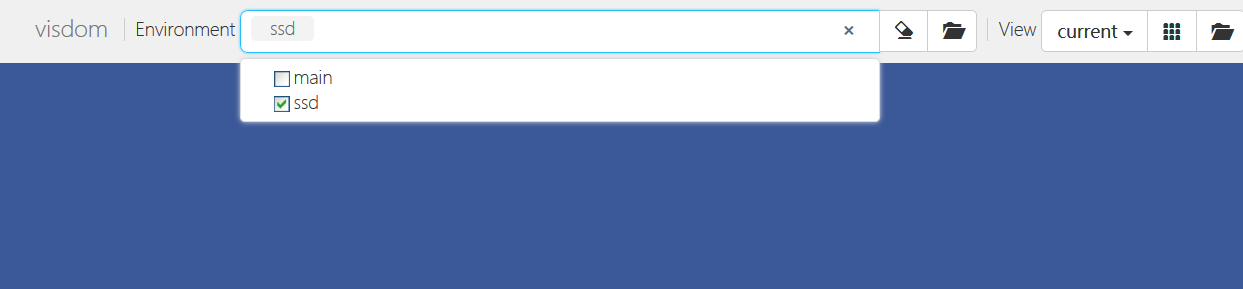

Next two functions are written to support visdom, just run them

In [3]:
def create_vis_plot(_xlabel, _ylabel, _title, _legend):
    return viz.line(
        X=torch.zeros((1,)).cpu(),
        Y=torch.zeros((1, 3)).cpu(),
        opts=dict(
            xlabel=_xlabel,
            ylabel=_ylabel,
            title=_title,
            legend=_legend
        )
    )
def update_vis_plot(iteration, loc, conf, window1, update_type,
                    epoch_size=1):
    viz.line(
        X=torch.ones((1, 3)).cpu() * iteration,
        Y=torch.Tensor([loc, conf, loc + conf]).unsqueeze(0).cpu() / epoch_size,
        win=window1,
        update=update_type
    )

Define visual coordinates, titles and create plots

In [4]:
vis_title = 'SSD.PyTorch on Voc2007'
vis_legend = ['Loc Loss', 'Conf Loss', 'Total Loss']
iter_plot = create_vis_plot('Iteration', 'Loss', vis_title, vis_legend)

In [5]:
epoch_plot = create_vis_plot('Epoch', 'Loss', vis_title, vis_legend)

### loading the data

load dataset by VOCDetection defined in voc0712.py

In [6]:
val_set = voc0713.VOCDetection(root = Config.dataset_root,
                                image_sets=  [('2007', 'val1')],
                                transform=augmentations.SSDAugmentation(Config.image_size,Config.MEANS))

train_dataset = voc0712.VOCDetection(root = Config.dataset_root,
                                image_sets=  [('2007', 'train')],
                                transform=augmentations.SSDAugmentation(Config.image_size,Config.MEANS))

use Class 'Dataloader' to encapsulate the customized dataset into a batch size tensor according to the batch size and shuffle, which is used for subsequent training.

In [7]:
data_loader = data.DataLoader(train_dataset, Config.batch_size,
                              num_workers=Config.data_load_number_worker,
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

### Set up a network and initialize parameters

In [8]:
net = ssd_net_vgg.SSD()
net.apply(weights_init) # initialize parameters

vgg_weights = torch.load('./weights/vgg16_reducedfc.pth') # load parameters of vgg16
net.vgg.load_state_dict(vgg_weights)

if torch.cuda.is_available(): #Config.use_cuda:
    net = torch.nn.DataParallel(net)
    net.cuda()
    
net.train()

DataParallel(
  (module): SSD(
    (vgg): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

### Load loss function, optimizer and define training epochs

In [9]:
loss_fun = loss_function.LossFun() #load the loss function
#loss_fun = DataParallelCriterion(loss_fun,device_ids=[0,1,2])

optimizer = optim.SGD(net.parameters(), lr=Config.lr, momentum=Config.momentum,
                      weight_decay=Config.weight_decacy) #load optimizer
iteration = 0 
epoch = 0
step_index = 0  
#before_epoch = -1
epoch_size = len(train_dataset) // Config.batch_size
batch_iterator = iter(data_loader)
loss_loc = 0
loss_conf = 0

### Begin training

Next cell is the training process, for training process, the model will be saved every 100 iterations like `weights/ssd_voc_100.pth` and after finishing all the iterations the model will be saved as `weights/ssd_voc_12000.pth`

For the notebook aims to show the process of training, I just train 16 iterations in next cell, so you wil finally get one model `weights/ssd_voc_12000.pth`, obviously the performance of this model is impossible to be good. In order to show the testing process, I use the model `weights/ssd300_voc_120000.pth` which I have trained before. It will be shown in testing part

In [10]:
for iteration in range(0,16): #16 iterations

    if iteration != 0 and (iteration % epoch_size == 0):

        update_vis_plot(epoch, loss_loc, loss_conf, epoch_plot,
                    'append', epoch_size) 

        loss_loc = 0
        loss_conf = 0
        epoch += 1

    if iteration in Config.lr_steps:
        step_index+=1 
        adjust_learning_rate(optimizer,Config.gamma,step_index) 
    img, target = next(batch_iterator)
    if Config.use_cuda:
        img = img.cuda()
        target = [ann.cuda() for ann in target]
    img = torch.Tensor(img)

    t0 = time.time() 

    loc_pre,conf_pre = net(img) 
    priors = utils.default_prior_box()
    optimizer.zero_grad()  
    loss_l,loss_c = loss_fun((loc_pre,conf_pre),target,priors) 
    loss = loss_l + loss_c 
    #print(loss)
    loss.backward() 
    optimizer.step() 

    t1 = time.time()

    loss_loc += loss_l.item()
    loss_conf += loss_c.item()

    if iteration % 5 == 0: 
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')
        random_batch_index = np.random.randint(img.size(0))
        viz.image(img.data[random_batch_index].cpu().numpy())
        
    update_vis_plot(iteration, loss_l.item(), loss_c.item(),
                    iter_plot, 'append') 

    if iteration % 100 == 0 and iteration!=0:  
        torch.save(net.state_dict(), 'weights/ssd_voc_' +
                    repr(iteration) + '.pth')

torch.save(net.state_dict(), 'weights/ssd_voc_12000.pth') 


C:\anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 6.2875 sec.
iter 0 || Loss: 27.7886 || timer: 1.1088 sec.
iter 5 || Loss: 17.2271 || timer: 1.1502 sec.
iter 10 || Loss: 15.8659 || timer: 1.1170 sec.
iter 15 || Loss: 19.5498 || 

when you begin running the above cell, the training begins, you can see the loss-iteration and loss-epoch curve at http://localhost:8097 like this, it's Real-time
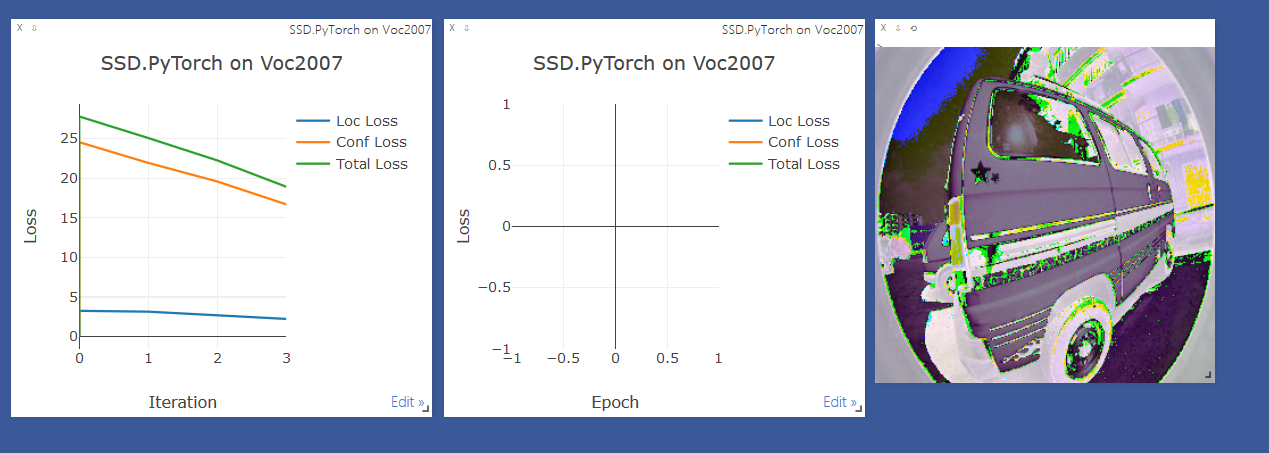

## Testing process

Set the size of images which will be showed

In [11]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
pylab.rcParams['figure.figsize'] = (25.0, 10.0)

colors_tableau defines the colors of the bounding boxes by different classes

In [12]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),(158, 218, 229),(158, 218, 229)]

loading model, here `./weights/ssd300_voc_120000.pth`is the weights I have trained.

In [13]:
net = SSD()    # initialize SSD
net = torch.nn.DataParallel(net)
net.train(mode=False)
net.load_state_dict(torch.load('./weights/ssd300_voc_120000.pth',map_location=lambda storage, loc: storage))

<All keys matched successfully>

Process the test image so that the image can be input into the model

In [14]:
image = cv2.imread('./test6.jpg', cv2.IMREAD_COLOR)
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy() 
x = torch.from_numpy(x).permute(2, 0, 1)
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()

Here is my test image, you can change it by modifying the path in the first line of the above cell

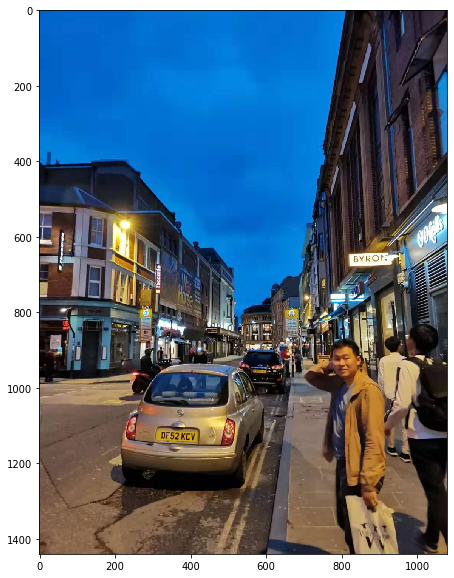

In [15]:
img_2 = image[:,:,[2,1,0]]
plt.imshow(img_2)

In [16]:
y = net(xx)
softmax = nn.Softmax(dim=-1)
detect = Detect(config.class_num, 0, 200, 0.01, 0.45) 
priors = utils.default_prior_box()

loc,conf = y
loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

detections = detect(
    loc.view(loc.size(0), -1, 4),
    softmax(conf.view(conf.size(0), -1,config.class_num)),
    torch.cat([o.view(-1, 4) for o in priors], 0)
).data

labels = VOC_CLASSES
top_k=10

# plt.imshow(rgb_image)  # plot the image for matplotlib

# scale each detection back up to the image
scale = torch.Tensor(image.shape[1::-1]).repeat(2)
#print(detections)
data = []


..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


begin detection and draw the boundIng boxes on the image, here I set the threshold to 0.6, which means if the confidence of a bounding box is below 0.6, it won't be drawn, also you can change it by modifying the 0.6 at the third line.

In [17]:
 for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:

        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors_tableau[i]
        cv2.rectangle(image,(pt[0],pt[1]), (pt[2],pt[3]), color, 10)
        cv2.putText(image, display_txt, (int(pt[0]), int(pt[1]) + 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 4, 8)
        j+=1

show the image

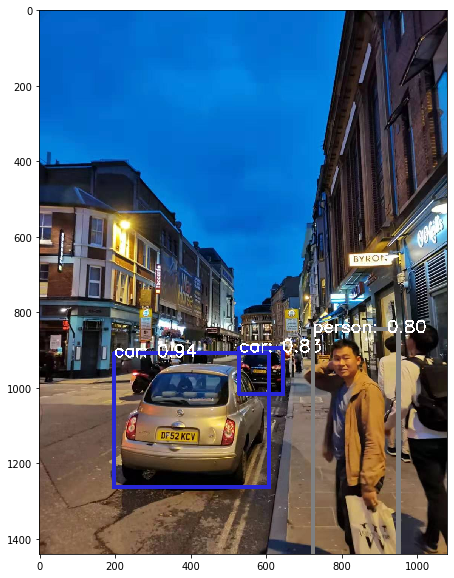

In [18]:
cv2.imwrite('result.png',image)
img_2 = image[:,:,[2,1,0]]
plt.imshow(img_2)

## Eval process

The notebook aims to show the process of eval, so I just use 61 images as validation data, which are stored in val1.txt  

Warning is normal，just ignore it.

In [19]:
net.eval()
APs, mAP = test_net(test_save_dir,net,val_set,
                    top_k, thresh=0.01)

..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd fu

..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd fu

..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
..\torch\csrc\autograd\python_function.cpp:622: UserWarning: Legacy autograd fu

Evaluating detections
AP for aeroplane = 1.0000
AP for bicycle = 1.0000
AP for bird = 1.0000
AP for boat = 1.0000
AP for bottle = 0.8773
AP for bus = 1.0000
AP for car = 0.9879
AP for cat = 1.0000
AP for chair = 0.9008
AP for cow = 1.0000
AP for diningtable = 1.0000
AP for dog = 0.9697
AP for horse = 1.0000
AP for motorbike = 0.0000
AP for person = 0.7976
AP for pottedplant = 0.0000
AP for sheep = 1.0000
AP for sofa = 1.0000
AP for train = 1.0000
AP for tvmonitor = 1.0000
Mean AP = 0.8767


C:\Users\野生甲鱼\Desktop\company\ssd_pytorch-master\voc_eval.py:166: RuntimeWarning: invalid value encountered in true_divide
  rec = tp / float(npos)
C:\Users\野生甲鱼\Desktop\company\ssd_pytorch-master\voc_eval.py:38: RuntimeWarning: invalid value encountered in greater_equal
  if np.sum(rec >= t) == 0:


A picture to show the eval result

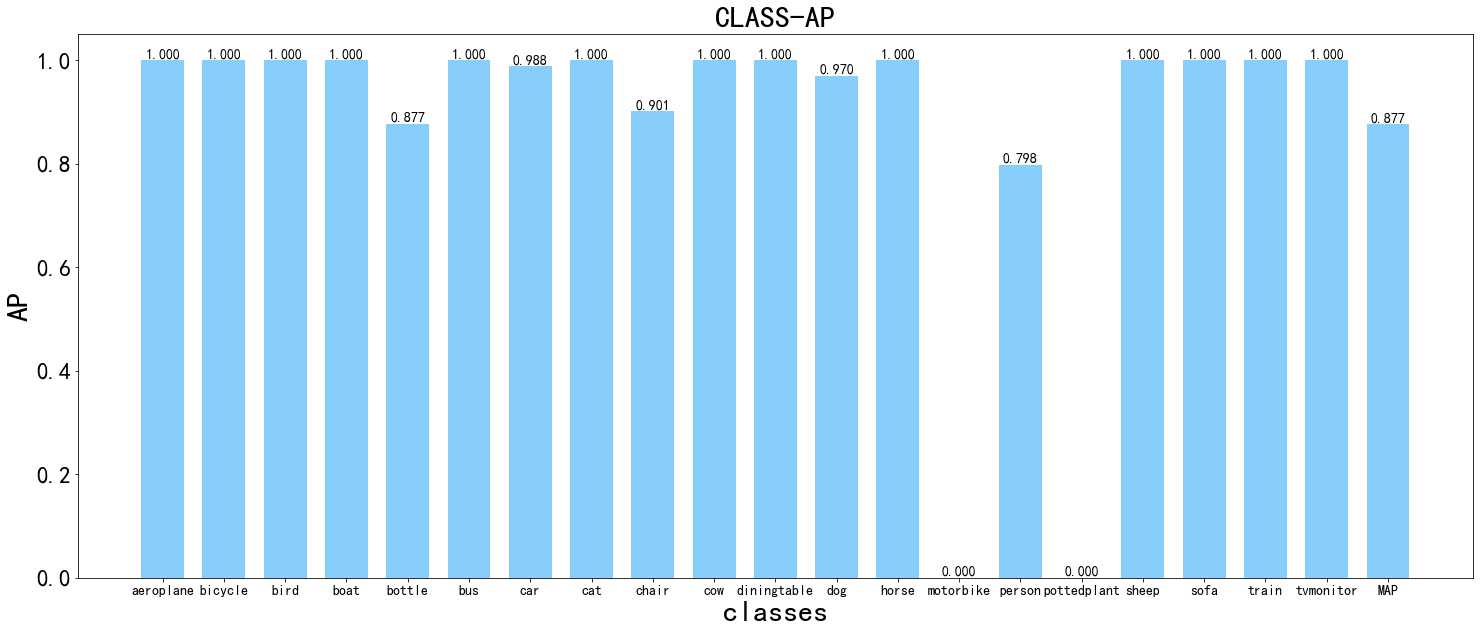

In [22]:
plt.rcParams['font.sans-serif'] = ['SimHei']
# mp.rcParams['axes.unicode_minus'] = False
oranges = np.array(APs)
oranges = np.append(oranges,mAP)
plt.figure()
plt.title('CLASS-AP', fontsize=30)
plt.xlabel('classes', fontsize=30)
plt.ylabel('AP', fontsize=30)
#plt.tick_params(labelsize=10)
#plt.grid(linestyle=':', axis='y')
x = np.arange(21)
b = plt.bar(x , oranges, 0.7, color='#87CEFA', label='Oranges', align='center')

plt.xticks(x, [ # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor','MAP'],fontsize=14
)

plt.yticks(fontsize=23)
for i in b:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % float(h), ha='center', va='bottom',fontsize=14)
#plt.legend()
plt.show()